In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

c:\Users\mrmoh\anaconda3\envs\Nerf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
H = 400
W = 400
f = 1200

In [3]:
rays_o = np.zeros((H*W, 3))
rays_d = np.zeros((H*W, 3))

u = np.arange(W)
v = np.arange(H)
u, v = np.meshgrid(u, v)

dirs = np.stack((u - W / 2,
                 -(v - H / 2),
                 - np.ones_like(u) * f), axis=-1)
rays_d = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)
rays_d = rays_d.reshape(-1, 3)

In [4]:
def plot_rays(o, d, t):
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca(projection='3d')
    
    pt1 = o
    pt2 = o + t * d
    
    for p1, p2 in zip(pt1[::100], pt2[::100]):
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]])
    
    
    plt.show()

In [5]:
class Sphere():
    
    def __init__(self, p, r, c):
        self.p = p
        self.r = r
        self.c = c
        
    def intersect(self, x):
        """
        :param x: points [batch_size, 3]
        """
        
        # (x- xc)^2 + (y-yc)^2 + (z-zc)^2 <= r^2 
        
        cond = (x[:, 0] - self.p[0])**2 + (x[:, 1] - self.p[1])**2 + (x[:, 2] - self.p[2])**2 <= self.r**2
                
        num_rays = x.shape[0]
        colors = torch.zeros((num_rays, 3))
        density = torch.zeros((num_rays, 1))
        
        colors[cond] = self.c
        density[cond] = 10
        
        return colors, density

In [11]:
t = np.array([1,2,3,4,5])
print(t[1:] - t[:-1])



print(t[1:])

print(t[:-1])

[1 1 1 1]
[2 3 4 5]
[1 2 3 4]


In [12]:
rays_o.shape

(160000, 3)

In [13]:
rays_d.shape

(160000, 3)

In [14]:
def rendering(rays_o, rays_d, tn, tf, nb_bins=100, device='cpu'):
    # here we take nb_bins to be 100 so as to have a smooth curve (like a graph)
    t = torch.linspace(tn, tf, nb_bins).to(device) # [nb_bins]
    #here we created few t values from tn to tf so that we can have a smooth curve
    # device is cpu or gpu. if we need gpu then we need to change the device to cuda

    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10])))
    #here delta is difference between t_i+1(t[1:]) and t_i(t[:-1]) -> [nb_bins-1] cuz o/p is 1 1 1 1 
    #here we concatenate t_i+1 - t_i with 1e10 so that we get very large number (or infinity) at the end

    x = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1) # [nb_rays, nb_bins, 3]

    print(x.shape)
    

In [15]:
rendering(rays_o, rays_d, 0.8, 1.2)

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [18]:
rendering(torch.from_numpy(rays_o), torch.from_numpy(rays_d), 0.8, 1.2)
#output basically says 160000 rays x 100 bins x 3 diemensions

torch.Size([160000, 100, 3])


In [19]:
def compute_accumulated_transmittance(betas):
    #here cumprod is cumulative product -> betas[0] * betas[1] * betas[2] * betas[3] * ...
    # here we are computing the accumulated transmittance
    accumulated_transmittance = torch.cumprod(betas, 1) 
    accumulated_transmittance[:, 0] = 1.
    return accumulated_transmittance


#here model is used to take color and density of the sphere at time t
# in the intersect function we are taking the color and density of the sphere at time t
# that is used in the rendering function

def rendering(model, rays_o, rays_d, tn, tf, nb_bins=100, device='cpu'):
    # here we take nb_bins to be 100 so as to have a smooth curve (like a graph)
    t = torch.linspace(tn, tf, nb_bins).to(device) # [nb_bins]
    #here we created few t values from tn to tf so that we can have a smooth curve
    # device is cpu or gpu. if we need gpu then we need to change the device to cuda

    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10])))
    #here delta is difference between t_i+1(t[1:]) and t_i(t[:-1]) -> [nb_bins-1] cuz o/p is 1 1 1 1 
    #here we concatenate t_i+1 - t_i with 1e10 so that we get very large number (or infinity) at the end

    x = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1) # [nb_rays, nb_bins, 3]
    # x = o + t * d
    # here t - [nb_bins, 1]
    # o - [nb_rays, 3]
    # d - [nb_rays, 3]
    # so, x - [nb_rays, nb_bins, 3]
    # so we unsqueeze(1) to make it [nb_rays, 1, 3] and unsqueeze(0) to make it [1, nb_bins, 3]
    
    # this tells where the ray intersects with the sphere at time t 
    
    colors, density = model.intersect(x.reshape(-1, 3))
    

    #the below color reshaping is done to make it [nb_rays, nb_bins, 3] 
    # it means to make color in 3 channel and density in 1 channel

    colors = colors.reshape((x.shape[0], nb_bins, 3)) # [nb_rays, nb_bins, 3]
    density = density.reshape((x.shape[0], nb_bins))
    
    alpha = 1 - torch.exp(- density * delta.unsqueeze(0)) # [nb_rays, nb_bins, 1]
    T = compute_accumulated_transmittance(1 - alpha) # [nb_rays, nb_bins, 1]

    c = (T.unsqueeze(-1) * alpha.unsqueeze(-1) * colors).sum(1) # [nb_rays, 3]
    #here we multiply T with alpha and sum it with colors to get the final color
    # also .sum(1) makes it [nb_rays, 3] from  [nb_rays, nb_bins, 3]

    
    return c

In [20]:
model = Sphere(torch.tensor([0, 0, -1]), 0.1, torch.tensor([1., 0., 0.]))
px_colors = rendering(model, torch.from_numpy(rays_o), torch.from_numpy(rays_d), 0.8, 1.2)

In [21]:
img = px_colors.reshape(H, W, 3).cpu().numpy()

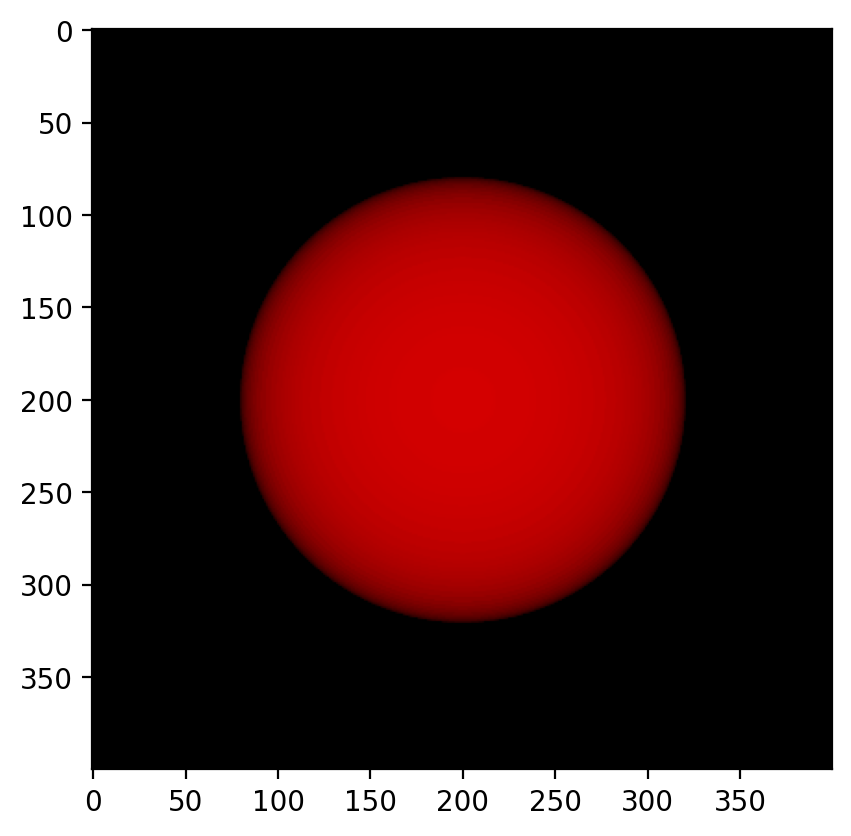

In [22]:
plt.figure(dpi=200)
plt.imshow(img)